# CSCI 3202, Spring 2023


# Simulated Annealing Notebook

Before we begin, let's load a few packages that we might find useful.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as stats

<br>

---

<br>


## Problem 1: Simulated annealing



### (1a) 

First, we need to either create a new class for a simulated annealing `problem`, or sub-class our `problem` class from earlier. That shouldn't be too bad - the main difference is that instead of the best move at any given point, we need to select a random one.

In addition to the `objective_function` argument during construction, we also ought to include the `schedule_function` for the temperature updates as time goes on (which moderate how likely we are to take sub-optimal steps). (We will define that one next!)

In [67]:
class state:

    def __init__(self, node, value):
        self.node = node
        self.value = value 

In [68]:
class problem:
    
    def __init__(self, initial, objective_function, stepsize):
        self.initial_state = initial
        self.current_state = initial
        self.objective_function = objective_function
        self.stepsize = stepsize
        
    def moves(self):
        '''return all possible moves to make from the current_state'''
        all_moves = []
        # could move right...
        all_moves.append(self.current_state.node + self.stepsize)
        # ... or left!
        all_moves.append(self.current_state.node - self.stepsize)
        return all_moves

In [69]:
class problem_anneal(problem):
#    def __init__(self, initial, objective_function, stepsize):

    def __init__(self, initial, objective_function, schedule_function, stepsize):
        problem.__init__(self, initial, objective_function, stepsize)
        self.schedule_function = schedule_function

    def random_move(self):
        '''return a random move, possible from the current_state'''
        all_moves = self.moves()
        next_move = np.random.choice(all_moves)
        return next_move, self.objective_function(next_move)

In [88]:
# JED
#
# Expanded look at functions

# First, we define an objective function.  We use a very easy to 
# optimize version.  We make it negative so we can minimize it

def gaussian_objective(state):
    return -stats.norm.pdf(x=state, loc=5, scale=2)

#
# problem_anneal() wants a schedule function

# Next, we create a problem

initial=state(1.0,gaussian_objective(1.0))
test=problem(initial,gaussian_objective,0.05)

# Print the variables in problem

In [92]:
# JED
test.__dict__

{'initial_state': <__main__.state at 0x7fdfca554370>,
 'current_state': <__main__.state at 0x7fdfca554370>,
 'objective_function': <function __main__.gaussian_objective(state)>,
 'stepsize': 0.05}

In [93]:
# JED
test.moves()

[1.05, 0.95]

**Note** that here I've sub-classed `problem`. In general, it might make more sense to just add more methods to a generic problem class.


### (1b)  Find a temperature schedule

Now, we need to actually write our code for the simulated annealing algorithm.  That's a bit more involved than the hill-climbing.

The trickiest part is deciding the form for (1) the temperature/time schedule $T(t)$ ($T$ is temperature, $t$ is time), and (2) the accept/reject probability as a function of temperature and the difference in model performance between our current and proposed moves, $\Delta E$.

First, let's play around with the **temperature schedule**.  A typical choice might look like:

$$T(t) = \dfrac{C}{(t+1)^p}$$

where $C$ and $p$ are some constants you can tune. The +1 in the denominator is to avoid divide-by-0 situations. 

Now a typical choice for the probability of accepting a move, based on $\Delta E = f(\text{current state}) - f(\text{proposed state})$ (where $f$ is the objective function that we want to *minimize* here) is:

$$p_{accept} = \exp{\left(\dfrac{\Delta E}{T(t)}\right)}$$

Note that:
1. if we wanted instead to *maximize* $f$, we just need to throw a $-$ sign in front of $\Delta E$, and
2. if we find that $f(\text{proposed state}) < f(\text{current state})$, then $\Delta E > 0$ and we should accept the move with $p_{accept} = 1$.

That form for $p_{accept}$ is based loosely off of Newton's Law of Cooling and good old-fashioned thermodynamics.  Say what you will about Newton ([he was a jerk](https://jencyclopedic.wordpress.com/2014/04/02/isaac-newton-was-a-dick/)), but his law of cooling is pretty nice.

See if you can choose $C$ and $p$ such that the acceptance probability $p_{accept}$ starts near 1 and decreases smoothly to somewhere around 20% for $t$ ranging from 0 to 1,000.
For these preliminary tests, let's just assume that $\Delta E$ is constant at $\Delta E = -0.2$.

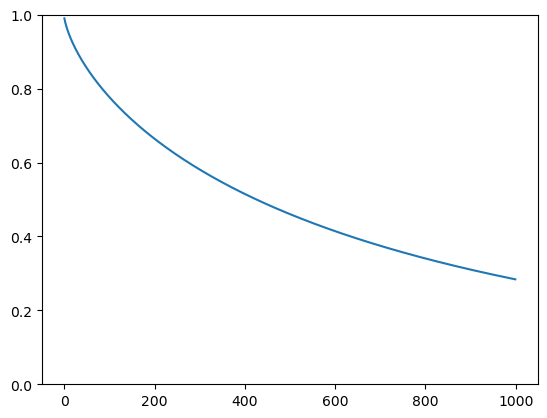

In [43]:
time = list(range(1000))
temperature = [20/(tt+1)**.7 for tt in time]
paccept = [np.exp(-0.2/temp) for temp in temperature]

plt.plot(time, paccept)
plt.ylim([0,1])
plt.show()

Armed with these choices for $C$ and $p$, we can define a `schedule(time)` function for $T(t)$:

In [44]:
def schedule(time):
    '''some sort of mapping from time to temperature, to represent how we should be 
    "cooling off" - that is, accepting wacky solutions with lower and lower probability'''
    C = 20#
    p = 0.7#
    temperature = C/(time+1)**p
    
    return temperature

In [109]:
# JED
test_problem=problem_anneal(initial=initial,objective_function=gaussian_objective,
                            schedule_function=schedule,stepsize=0.05)

test_problem.__dict__

{'initial_state': <__main__.state at 0x7fdfca554370>,
 'current_state': <__main__.state at 0x7fdfca554370>,
 'objective_function': <function __main__.gaussian_objective(state)>,
 'stepsize': 0.05,
 'schedule_function': <function __main__.schedule(time)>}

In [110]:
# JED
print(test_problem.moves())
[gaussian_objective(test_problem.moves()[i]) for i in range(len(test_problem.moves()))]

[1.05, 0.95]


[-0.02837070404991201, -0.025670874600384728]

In [111]:
# JED
test_problem.random_move()

(0.95, -0.025670874600384728)


### (1c)  Define our simulated annealing algorithm

Now that we have a temperature updating `schedule`, which defines how we accept/reject proposed moves for our simulated annealing algorithm, we can actually turn our pseudocode into real code!

Let's write a `simulated_annealing` algorithm. Similar to the `hill_climbing` one above, we should take as arguments only the `problem` statement and maybe one other argument for the number of iterations to run the algorithm.

In [34]:
def simulated_annealing(problem, n_iter):
    
    current = problem.initial_state
    
    for t in range(n_iter):
        temperature = problem.schedule_function(t)
        nextMove,nextValue = problem.random_move()
        delta_obj = current.value - nextValue
        
        if delta_obj > 0:
            problem.current_state.node, problem.current_state.value = nextMove,nextValue
            
        else:
            p_accept = np.exp(delta_obj/temperature)
            
            accept = np.random.choice([True,False],p=[p_accept,1-p_accept])
            
            if accept:
                problem.current_state.node, problem.current_state.value = nextMove,nextValue
                
                
    return problem.current_state


### (1d) Let's solve that problem from class!


You know that plot in class of an example objective function we wanted to use simulated annealing to minimize?

Well...  it's just the `several_gaussian_objective` from **the Hill-Climbing Notebook** but ***upside-down!!!***

(You should feel free to rename this function...)

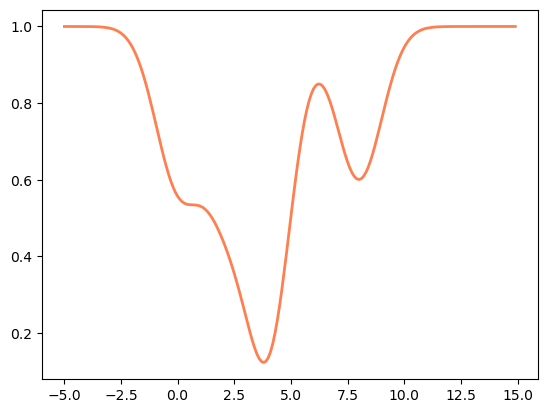

In [9]:
def not_such_a_mystery_anymore_objective(state):
    locs = [0,2.1,4,4,8] # centers of a bunch of normal distributions
    objective_value = 0
    # objective function is actually just the sum of a bunch of normal pdfs
    for loc in locs:
        objective_value += stats.norm.pdf(state, loc=loc, scale=1)
    return 1-objective_value

x = np.arange(start=-5, stop=15, step=0.1)
fx = [not_such_a_mystery_anymore_objective(xk) for xk in x]

plt.plot(x, fx, c='coral', lw=2)
plt.show()

Now we're ready to use our simulated annealing algorithm to solve this problem!
1. Define an `initial_state` and declare a relevant `problem`
2. Feed these into your simulated annealing algorithm to attempt to find the global minimum

If you're having trouble hitting the global minimum, try playing around with different values for:
* stepsize (taking tiny steps makes it harder to get out of a local minimum)
* schedule (mapping from time to temperature - if you lower the temperature slowly enough, the algorithm *will* find the global minimum with probability approaching 1)
* start with initial `state` that you know should lead into the global minimum. Once you are happy that you can reliably optimize starting from there, move away and see how you need to modify the stepsize and/or temperature schedule to keep making it to the minimum.
* try using a **random restart** range of initial states, similarly to how we tackled this problem (upside-down) using hill-climbing, and plotting a histogram of the ensemble results

In [35]:
initial = 9
initial_state = state(node=initial, value=not_such_a_mystery_anymore_objective(initial))
problem_from_class = problem_anneal(initial=initial_state, objective_function=not_such_a_mystery_anymore_objective, 
                        schedule_function=schedule, stepsize=0.3)

out = simulated_annealing(problem_from_class, n_iter=10**3)

print(out.node, out.value)

-9.299999999999999 1.0


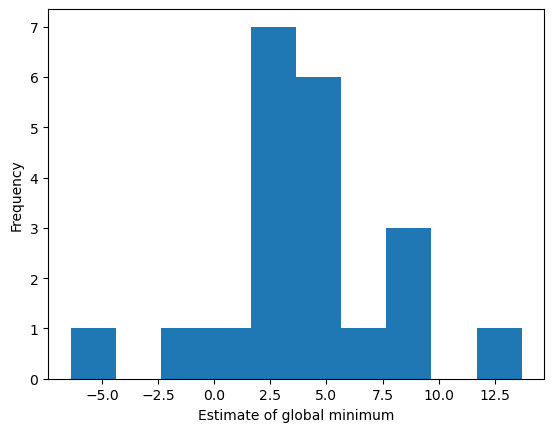

In [36]:
initial = np.arange(start=0, stop=10.5, step=0.5)
out = []
min_val = []
for init in initial:
    initial_state = state(node=init, value=not_such_a_mystery_anymore_objective(init))
    problem_from_class = problem_anneal(initial=initial_state, objective_function=not_such_a_mystery_anymore_objective, 
                            schedule_function=schedule, stepsize=0.2)
    out.append(simulated_annealing(problem_from_class, n_iter=10**3).node)
    min_val.append(simulated_annealing(problem_from_class, n_iter=10**3).value)
plt.hist(out)
plt.xlabel('Estimate of global minimum')
plt.ylabel('Frequency')
plt.show()

In [12]:
minimum = np.min(min_val)

In [13]:
minimum

0.12584021893220332

In [14]:
# True minimum of the given function
min(zip(fx, x))

(0.12351464467865314, 3.7999999999999687)